# Import and High-Level Setup

In [1]:
# General Python Packages
import os, time, numbers, math

# Torch Packages
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torch import nn
from torch.nn import DataParallel
from torch.nn import Module

# General Analytics Packages
import pandas as pd
import numpy as np

# Visualization / Image Packages
import matplotlib.pyplot as plt
from PIL import Image

# Randomization Functions
from random import random as randuni

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
# Put MatPlotLib in interactive mode
plt.ion()

# Plot graphics inline in the notebook
%matplotlib inline

# Define Data Manipulation Classes

### Helper Utility Classes

In [3]:
def is_image_file(fname):
    """Checks if a file is an image.
    Args:
        fname (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    return fname.lower().endswith('.png')

def create_label_maps(details_df):
    """ Take a descriptive dataframe and extract the unique labels and map to index values
    Args:
        details_df: Dataframe with the image details
    Returns:
        label_list: list of unique labels in the dataframe
        label_to_index: map from labels to indices
    """
    """ TODO: Research paper also excludes these labels but need to figure out how to handle
              cases that have these as positive findings (completely exclude?)
    excluded_labels = ['Edema','Hernia','Emphysema','Fibrosis','No Finding'
                      'Pleural_Thickening','Consolidation']
    """
    excluded_labels = ['No Finding']
    
    label_groups = details_df['Finding Labels'].unique()
    unique_labels = set([label for sublist in label_groups.tolist() for label in sublist.split('|')])
    
    # Drop some label that we do not want to include
    unique_labels = [l for l in unique_labels if l not in excluded_labels]

    index_to_label = {idx: val for idx, val in enumerate(unique_labels)}
    label_to_index = {val: idx for idx, val in index_to_label.items()}

    label_list = list(label_to_index.keys())

    return label_list, label_to_index

def create_image_list(dir):
    """ Create a full list of images available 
    Args:
        dir (string): root directory of images with subdirectories underneath
                      that have the .png images within them
    Returns:
        image_list: list of tuples with (image_name, full_image_path)
    """
    image_list = []
    dir = os.path.expanduser(dir)
    for subfolder in sorted(os.listdir(dir)):
        d = os.path.join(dir, subfolder)
        if not os.path.isdir(d):
            continue
        for subfolder_path, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(subfolder_path, fname)
                    image_list.append((fname, path))
    return image_list

def pil_loader(path):
    """ Opens path as file with Pillow (https://github.com/python-pillow/Pillow/issues/835)
    Args:
        path (string): File path to the image
    Returns:
        img: Image in RGB format
    """
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
        
def imshow(inp, title=None):
    """ Convert tensor array to an image (only use post-dataset transform) """
    inp = inp[0]
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

### Implementation of Torch's Dataset

In [4]:
class XrayImageSet(Dataset):
    """
    Args:
        image_root (string): root directory of the images in form image/subfolder/*.png
        csv_file (string): path to the CSV data file
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        labels (list): list of the possible label names.
        label_to_index (dict): look from label name to a label index
        imgs (list): List of (filename, image path) tuples
    """
    
    def __init__(self, image_root, csv_file, transform=None, target_transform=None, loader = pil_loader):
        """ Create an instance of the Xray Dataset """
        img_details = pd.read_csv(csv_file)
        
        labels, label_to_index = create_label_maps(img_details)
        imgs = create_image_list(image_root)

        self.imgs = imgs
        self.image_details = img_details
        self.image_root = image_root
        self.labels = labels
        self.label_to_index = label_to_index
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.max_label_index = max(label_to_index.values())

    def __getitem__(self, index):
        """ Get image,labels pair by index
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        fname, path = self.imgs[index]
        target = self.get_one_hot_labels(fname)
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """ Calculate length of the dataset (number of images) """
        return len(self.imgs)
    
    def get_labels(self, fname):
        """ Return the label string for the file """
        return self.image_details[self.image_details['Image Index'] == fname]['Finding Labels'].values[0]
    
    def one_hot_labels(self, labels):
        """ Convert the labels string (with each label separated by |) into 1-hot encoding """
        if labels == None:
            return None
        
        split_label_indices = [self.label_to_index.get(label)
                               for label in labels.split('|')
                               if label != 'No Finding']
        
        out = [1 if idx in split_label_indices else 0 for idx in range(self.max_label_index+1)]
        # This code UNHOTs the labels:
        # out = '|'.join([index_to_label.get(idx) for idx, val in enumerate(one_hot_tuple) if val == 1])
        return out

    def get_one_hot_labels(self, fname):
        """ Get the 1-hot encoded label array for the provided file """
        labels = self.get_labels(fname)
        one_hot_labels = self.one_hot_labels(labels)
        return torch.FloatTensor(one_hot_labels)

#### mean ± std. dev. of 7 runs, 10000000 loops each

#### Time for __get_item__
```
%timeit img_data_train[3] # 30.8 ms ± 544 µs per loop
```

#### Breakdown for __get_item__
```
%timeit img_data_train.imgs[8] # 63 ns ± 0.0057 ns per loop
%timeit img_data_train.get_one_hot_labels('00011558_012.png') # 8.72 ms ± 9.44 µs per loop
%timeit img_data_train.loader('/user/images/images_006/00011558_012.png') # 14.1 ms ± 3.41 µs per loop
%timeit img_data_train.transform(img) # 3.17 ms ± 1.32 µs per loop
```

#### Breakdown for loader() from __get_item__
```
%timeit open('/user/images/images_006/00011558_012.png', 'rb') # 7.72 µs ± 13.4 ns per loop
%timeit Image.open(f) # 37.5 µs ± 2.25 µs per loop
%timeit img.convert('RGB') # 498 µs ± 149 ns per loop
```

### Create the dataset with necessary transformations

In [5]:
nn_input_size = 224
#nn_input_size = 1024

In [6]:
img_transforms = transforms.Compose(
    [transforms.Resize(nn_input_size),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [7]:
img_data_train = XrayImageSet(image_root = '/user/images/',
                              csv_file = '/user/img_details.csv',
                              transform = img_transforms,
                              target_transform = None)

img_data_train.imgs = [img for i, img in enumerate(img_data_train.imgs) if i % 10 > 0]# and randuni() < 0.1]

In [8]:
img_data_val   = XrayImageSet(image_root = '/user/images/',
                              csv_file = '/user/img_details.csv',
                              transform = img_transforms,
                              target_transform = None)

img_data_val.imgs = [img for i, img in enumerate(img_data_val.imgs) if i % 10 == 0]# and randuni() < 0.1]

In [9]:
print("Training Set Size: {}".format(len(img_data_train)))
print("Validation Set Size: {}".format(len(img_data_val)))

Training Set Size: 100908
Validation Set Size: 11212


### Put the dataset into a Dataloader to handle batching

In [10]:
batch_size = 64
num_gpus = torch.cuda.device_count()
pin_mem_setting = True

print("Number of GPU: {}".format(num_gpus))

Number of GPU: 1


In [11]:
img_loader_train = DataLoader(img_data_train,
                              batch_size = batch_size * num_gpus,
                              shuffle = True,
                              num_workers = 10,
                              pin_memory = pin_mem_setting)

img_loader_val   = DataLoader(img_data_val,
                              batch_size = batch_size * num_gpus,
                              shuffle = True,
                              num_workers = 10,
                              pin_memory = pin_mem_setting)

In [12]:
dataloaders = {
    'train': img_loader_train,
    'val': img_loader_val
}

# Define model training procedure

In [13]:
class printer_writer:
    def __init__(self, output_folder_path):
        self.start_time = time.strftime('%Y%m%d-%Hh%Mm%Ss')
        
        self.outprefix = output_folder_path + '/' + self.start_time
        
        # Print Output File
        self.print_out_path = self.outprefix + '_print.txt'
        self.print_out_file = open(self.print_out_path, 'w', 1)
        
    def printw(self, string):
        print(string)
        try:
            self.print_out_file.write(string + "\n")
        except: # Ignore errors
            pass
        
    def save_checkpoint(self, epoch, model, optimizer, scheduler, val_error):
        model_out_path = self.outprefix + '_model_' + str(epoch+1) + '.tar'
        
        torch.save({
            'epoch': epoch+1,
            'state': model.state_dict(),
            'optimizer': optimizer,
            'scheduler': scheduler,
            'val_error': val_error
        }, model_out_path)
        
    def close(self):
        self.print_out_file.close()

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, outfolder = '/user/xrayproj/output/'):
    since = time.time()
    scribe = printer_writer(outfolder)

    for epoch in range(num_epochs):
        scribe.printw('Epoch {}/{}'.format(epoch, num_epochs - 1))
        scribe.printw('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0
            obs_counter = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Store statistics (convert from autograd.Variable to float/int)
                loss_val = loss.data[0]
                correct_val = torch.sum( ((outputs.sigmoid()>0.5) == (labels>0.5)).long() ).data[0]
                
                running_loss += loss_val
                running_corrects += correct_val
                
                obs_counter += len(inputs)
                
                batch_loss = 1.0 * loss_val / len(inputs)
                batch_acc = 1.0 * correct_val / len(inputs)
                status = ' |~~ {}@{}  Loss: {:.6f} Acc: {:.4f}'.format(
                    phase, obs_counter, batch_loss, batch_acc)
                scribe.printw(status)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            scribe.printw('{}  Loss: {:.6f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                scribe.save_checkpoint(epoch, model, optimizer, scheduler, epoch_loss)

    time_elapsed = time.time() - since
    scribe.printw('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    scribe.close()

    return model

# Define Weighted Cost Metrics

In [15]:
def imbalance_weighted_bce_with_logit(input, target, size_average=True):
    if not (target.size() == input.size()):
        raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

    max_val = (-input).clamp(min=0)
    loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

    # Determine |P| and |N|
    positive_labels = target.sum()
    negative_labels = (1-target).sum()

    # Upweight the less common class (very often the 1s)
    beta_p = (positive_labels + negative_labels) / positive_labels
    beta_n = (positive_labels + negative_labels) / negative_labels

    # Adjust the losses accordingly
    loss_weight = target * beta_p + (1-target) * beta_n
    
    loss = loss * loss_weight

    if size_average:
        return loss.mean()
    else:
        return loss.sum()

In [16]:
class BCEWithLogitsImbalanceWeightedLoss(Module):
    def __init__(self, class_weight=None, size_average=True):
        super(BCEWithLogitsImbalanceWeightedLoss, self).__init__()
        self.size_average = size_average

    def forward(self, input, target):
        return imbalance_weighted_bce_with_logit(input, target, size_average=self.size_average)

# Setup Neural Network

### Define the model specifications

In [17]:
def ResNet18PlusFlexibleFC():
    # Create a base ResNet18 model
    m = models.resnet18(pretrained=True)
    for param in m.parameters():
        param.requires_grad = False

    # Replace the final FC layer
    m.fc = nn.Linear(m.fc.in_features, len(img_data_train.labels))
    
    return m

In [18]:
def ResNet50PlusFlexibleFC():
    # Create a base ResNet18 model
    m = models.resnet50(pretrained=True)
    for param in m.parameters():
        param.requires_grad = False

    # Replace the final FC layer
    m.fc = nn.Linear(m.fc.in_features, len(img_data_train.labels))
    
    return m

In [19]:
def ResNet18PlusFCFullyFlexible():
    # Create a base ResNet18 model
    m = models.resnet18(pretrained=True)

    # Replace the final FC layer
    m.fc = nn.Linear(m.fc.in_features, len(img_data_train.labels))
    
    return m

In [105]:
def BrandNewArchitecture():
    m = nn.Sequential(
            nn.Conv2d(1, 8, 2, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Conv2d(),
            nn.ReLU(),
            nn.MaxPool2d(),
            nn.Linear(H, D_out)
        )
    
    return m

### Pull the ResNet-18 pre-trained model and replace the fully connected layer at the end

In [22]:
#model_base = ResNet18PlusFlexibleFC()
#model_base = ResNet18PlusFCFullyFlexible()
model_base = ResNet50PlusFlexibleFC()

### Push model to CUDA/GPU

In [23]:
model_ft = DataParallel(model_base).cuda()

### Define loss measure and learning rates/procedures

In [24]:
#criterion = BCEWithLogitsImbalanceWeightedLoss()
criterion_base = nn.BCEWithLogitsLoss()

optimizer_ft = SGD(model_ft.module.fc.parameters(), lr=0.0001, momentum=0.9)
#optimizer_ft = SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [25]:
criterion = criterion_base.cuda()

### Future code for allowing optimization of the base layer with a lower learning rate

```
ignored_params = list(map(id, model.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params,
                     model.parameters())

optimizer = torch.optim.SGD([
            {'params': base_params},
            {'params': model.fc.parameters(), 'lr': opt.lr}
        ], lr=opt.lr*0.1, momentum=0.9)
```

# Begin Training Network (Normal Cost)

In [110]:
train_model(model_ft,
            criterion,
            optimizer_ft,
            exp_lr_scheduler,
            num_epochs=8)

Epoch 0/7
----------
 |~~ train@64  Loss: 0.011481 Acc: 6.3594
 |~~ train@128  Loss: 0.011471 Acc: 6.2969
 |~~ train@192  Loss: 0.011460 Acc: 6.3594
 |~~ train@256  Loss: 0.011437 Acc: 6.1719
 |~~ train@320  Loss: 0.011352 Acc: 6.3750
 |~~ train@384  Loss: 0.011356 Acc: 6.5000
 |~~ train@448  Loss: 0.011292 Acc: 6.4688
 |~~ train@512  Loss: 0.011278 Acc: 6.8594
 |~~ train@576  Loss: 0.011164 Acc: 7.0000
 |~~ train@640  Loss: 0.011089 Acc: 7.0312
 |~~ train@704  Loss: 0.011062 Acc: 6.9062
 |~~ train@768  Loss: 0.011015 Acc: 7.2812
 |~~ train@832  Loss: 0.010835 Acc: 7.5469
 |~~ train@896  Loss: 0.010854 Acc: 7.7344
 |~~ train@960  Loss: 0.010718 Acc: 7.8438
 |~~ train@1024  Loss: 0.010678 Acc: 7.9062
 |~~ train@1088  Loss: 0.010591 Acc: 8.2031
 |~~ train@1152  Loss: 0.010481 Acc: 8.4844
 |~~ train@1216  Loss: 0.010409 Acc: 8.5938
 |~~ train@1280  Loss: 0.010343 Acc: 8.8750
 |~~ train@1344  Loss: 0.010219 Acc: 9.1719
 |~~ train@1408  Loss: 0.010137 Acc: 9.2969
 |~~ train@1472  Loss: 0.01

 |~~ train@11712  Loss: 0.004805 Acc: 13.0312
 |~~ train@11776  Loss: 0.004137 Acc: 13.4531
 |~~ train@11840  Loss: 0.004379 Acc: 13.2812
 |~~ train@11904  Loss: 0.004817 Acc: 12.9844
 |~~ train@11968  Loss: 0.004396 Acc: 13.2500
 |~~ train@12032  Loss: 0.004363 Acc: 13.2656
 |~~ train@12096  Loss: 0.004373 Acc: 13.2812
 |~~ train@12160  Loss: 0.004535 Acc: 13.1719
 |~~ train@12224  Loss: 0.004498 Acc: 13.1406
 |~~ train@12288  Loss: 0.004281 Acc: 13.3438
 |~~ train@12352  Loss: 0.004352 Acc: 13.2656
 |~~ train@12416  Loss: 0.004153 Acc: 13.3750
 |~~ train@12480  Loss: 0.004273 Acc: 13.2812
 |~~ train@12544  Loss: 0.004749 Acc: 13.0156
 |~~ train@12608  Loss: 0.004240 Acc: 13.3438
 |~~ train@12672  Loss: 0.004494 Acc: 13.1250
 |~~ train@12736  Loss: 0.004436 Acc: 13.1875
 |~~ train@12800  Loss: 0.004221 Acc: 13.2812
 |~~ train@12864  Loss: 0.004167 Acc: 13.2969
 |~~ train@12928  Loss: 0.004291 Acc: 13.2344
 |~~ train@12992  Loss: 0.004092 Acc: 13.3750
 |~~ train@13056  Loss: 0.004259 A

 |~~ train@23168  Loss: 0.003894 Acc: 13.0781
 |~~ train@23232  Loss: 0.003272 Acc: 13.3594
 |~~ train@23296  Loss: 0.003450 Acc: 13.2812
 |~~ train@23360  Loss: 0.003315 Acc: 13.3438
 |~~ train@23424  Loss: 0.003120 Acc: 13.4062
 |~~ train@23488  Loss: 0.003849 Acc: 13.0625
 |~~ train@23552  Loss: 0.003677 Acc: 13.1562
 |~~ train@23616  Loss: 0.003482 Acc: 13.2812
 |~~ train@23680  Loss: 0.003695 Acc: 13.1719
 |~~ train@23744  Loss: 0.003220 Acc: 13.3906
 |~~ train@23808  Loss: 0.003684 Acc: 13.1406
 |~~ train@23872  Loss: 0.003616 Acc: 13.1875
 |~~ train@23936  Loss: 0.003685 Acc: 13.1250
 |~~ train@24000  Loss: 0.003628 Acc: 13.2031
 |~~ train@24064  Loss: 0.003702 Acc: 13.1094
 |~~ train@24128  Loss: 0.003560 Acc: 13.2031
 |~~ train@24192  Loss: 0.003490 Acc: 13.2812
 |~~ train@24256  Loss: 0.003422 Acc: 13.2812
 |~~ train@24320  Loss: 0.003445 Acc: 13.2812
 |~~ train@24384  Loss: 0.003689 Acc: 13.1562
 |~~ train@24448  Loss: 0.003481 Acc: 13.2031
 |~~ train@24512  Loss: 0.003297 A

 |~~ train@34624  Loss: 0.003180 Acc: 13.2969
 |~~ train@34688  Loss: 0.003463 Acc: 13.1562
 |~~ train@34752  Loss: 0.003419 Acc: 13.1406
 |~~ train@34816  Loss: 0.003369 Acc: 13.1562
 |~~ train@34880  Loss: 0.003602 Acc: 13.0781
 |~~ train@34944  Loss: 0.003452 Acc: 13.1875
 |~~ train@35008  Loss: 0.003257 Acc: 13.2500
 |~~ train@35072  Loss: 0.003040 Acc: 13.3281
 |~~ train@35136  Loss: 0.003152 Acc: 13.2500
 |~~ train@35200  Loss: 0.002889 Acc: 13.3594
 |~~ train@35264  Loss: 0.003348 Acc: 13.2031
 |~~ train@35328  Loss: 0.003305 Acc: 13.2188
 |~~ train@35392  Loss: 0.003158 Acc: 13.2969
 |~~ train@35456  Loss: 0.002881 Acc: 13.3906
 |~~ train@35520  Loss: 0.003744 Acc: 13.0156
 |~~ train@35584  Loss: 0.003068 Acc: 13.3125
 |~~ train@35648  Loss: 0.003173 Acc: 13.2656
 |~~ train@35712  Loss: 0.002860 Acc: 13.4219
 |~~ train@35776  Loss: 0.002782 Acc: 13.4219
 |~~ train@35840  Loss: 0.003211 Acc: 13.2656
 |~~ train@35904  Loss: 0.003159 Acc: 13.2344
 |~~ train@35968  Loss: 0.003096 A

 |~~ train@46144  Loss: 0.003093 Acc: 13.2500
 |~~ train@46208  Loss: 0.002879 Acc: 13.3125
 |~~ train@46272  Loss: 0.002927 Acc: 13.3281
 |~~ train@46336  Loss: 0.003637 Acc: 13.0469
 |~~ train@46400  Loss: 0.003093 Acc: 13.2188
 |~~ train@46464  Loss: 0.002940 Acc: 13.2969
 |~~ train@46528  Loss: 0.003200 Acc: 13.2188
 |~~ train@46592  Loss: 0.003583 Acc: 13.0469
 |~~ train@46656  Loss: 0.002736 Acc: 13.3906
 |~~ train@46720  Loss: 0.003439 Acc: 13.1250
 |~~ train@46784  Loss: 0.003360 Acc: 13.1406
 |~~ train@46848  Loss: 0.002893 Acc: 13.3438
 |~~ train@46912  Loss: 0.002779 Acc: 13.3750
 |~~ train@46976  Loss: 0.003077 Acc: 13.2500
 |~~ train@47040  Loss: 0.002842 Acc: 13.3281
 |~~ train@47104  Loss: 0.002911 Acc: 13.3438
 |~~ train@47168  Loss: 0.003205 Acc: 13.2344
 |~~ train@47232  Loss: 0.003451 Acc: 13.0938
 |~~ train@47296  Loss: 0.002975 Acc: 13.2656
 |~~ train@47360  Loss: 0.002948 Acc: 13.3281
 |~~ train@47424  Loss: 0.002505 Acc: 13.5156
 |~~ train@47488  Loss: 0.002778 A

Process Process-1:
Process Process-7:
Process Process-9:
Process Process-2:
Process Process-3:
Process Process-6:
Process Process-8:
Process Process-5:
Process Process-10:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "

  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/ImageFile.py", line 212, in load
    s = read(self.decodermaxblock)
  File "<ipython-input-86-4cc34eea5387>", line 68, in pil_loader
    return img.convert('RGB')
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 860, in convert
    self.load()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/ImageFile.py", line 212, in load
    s = read(self.decodermaxblock)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 860, in convert
    self.load()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/PngImagePlugin.py", line 608, in load_read
    return self.fp.read(read_bytes)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/PIL/ImageFile.py", line 212, in load
    s = read(self.decodermaxblock)
  File "<ipython-input-86-4cc34eea5387>", line 68, in pil_loader
    return img.convert('RGB')
  File "<ipython-input-86-4cc34eea5387>", line 68, in

### Save model results to S3

aws s3 cp ResNet18PlusFlexibleFC_Epoch9.tar s3://bdh-xrayproj-modelparameters/

import boto3

s3 = boto3.client('s3')
s3.list_buckets()

S3 Commands: http://docs.aws.amazon.com/cli/latest/userguide/using-s3-commands.html

Boto3 QuickStart: http://boto3.readthedocs.io/en/latest/guide/quickstart.html

Key Management: https://aws.amazon.com/blogs/security/a-safer-way-to-distribute-aws-credentials-to-ec2/

AWS IAM Rules: http://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles_use_switch-role-api.html

### Load model results back from S3

In [26]:
exp_lr_scheduler.last_epoch

9

# Analysis of Model Results

In [88]:
class TotalSumMeter:
    def __init__(self):
        self.obs_counter = 0.0
        self.total_pred = Variable(torch.FloatTensor(torch.zeros(14)), volatile=True)
        self.total_act = Variable(torch.FloatTensor(torch.zeros(14)), volatile=True)
        
    def update(self, preds, actuals):
        self.total_act += actuals.sum(0).cpu()
        self.total_pred += preds.sum(0).cpu()
        self.obs_counter += len(actuals)
        
    def get_results(self):
        return {
            'pred': self.total_pred / self.obs_counter,
            'act': self.total_act / self.obs_counter
            }

In [27]:
class MultiClassAUCMeter:
    """ Wrapper on the normal AUCMeter to handle multi-class predictions """
    def __init__(self, num_class):
        self.num_class = num_class
        self.meters = []
        for i in range(self.num_class):
            self.meters.append(AUCMeter())

    def add(self, output, target):
        for i in range(self.num_class):
            self.meters[i].add(output[:,i], target[:,i])
        
    def value(self):
        output = []
        for i in range(self.num_class):
            output.append(self.meters[i].value())
        return output

In [28]:
class AUCMeter:
    """
    SOURCE: https://github.com/pytorch/tnt/blob/master/torchnet/meter/aucmeter.py
    
    The AUCMeter measures the area under the receiver-operating characteristic
    (ROC) curve for binary classification problems. The area under the curve (AUC)
    can be interpreted as the probability that, given a randomly selected positive
    example and a randomly selected negative example, the positive example is
    assigned a higher score by the classification model than the negative example.
    The AUCMeter is designed to operate on one-dimensional Tensors `output`
    and `target`, where (1) the `output` contains model output scores that ought to
    be higher when the model is more convinced that the example should be positively
    labeled, and smaller when the model believes the example should be negatively
    labeled (for instance, the output of a signoid function); and (2) the `target`
    contains only values 0 (for negative examples) and 1 (for positive examples).
    """
    def __init__(self):
        super(AUCMeter, self).__init__()
        self.reset()

    def reset(self):
        self.scores = torch.DoubleTensor(torch.DoubleStorage()).numpy()
        self.targets = torch.LongTensor(torch.LongStorage()).numpy()

    def add(self, output, target):
        if torch.is_tensor(output):
            output = output.cpu().squeeze().numpy()
        if torch.is_tensor(target):
            target = target.cpu().squeeze().numpy()
        elif isinstance(target, numbers.Number):
            target = np.asarray([target])
        assert np.ndim(output) == 1, \
            'wrong output size (1D expected)'
        assert np.ndim(target) == 1, \
            'wrong target size (1D expected)'
        assert output.shape[0] == target.shape[0], \
            'number of outputs and targets does not match'
        assert np.all(np.add(np.equal(target, 1), np.equal(target, 0))), \
            'targets should be binary (0, 1)'

        self.scores = np.append(self.scores, output)
        self.targets = np.append(self.targets, target)

    def value(self):
        # case when number of elements added are 0
        if self.scores.shape[0] == 0:
            return 0.5

        # sorting the arrays
        scores, sortind = torch.sort(torch.from_numpy(self.scores), dim=0, descending=True)
        scores = scores.numpy()
        sortind = sortind.numpy()

        # creating the roc curve
        tpr = np.zeros(shape=(scores.size + 1), dtype=np.float64)
        fpr = np.zeros(shape=(scores.size + 1), dtype=np.float64)

        for i in range(1, scores.size + 1):
            if self.targets[sortind[i - 1]] == 1:
                tpr[i] = tpr[i - 1] + 1
                fpr[i] = fpr[i - 1]
            else:
                tpr[i] = tpr[i - 1]
                fpr[i] = fpr[i - 1] + 1

        tpr /= (self.targets.sum() * 1.0)
        fpr /= ((self.targets - 1.0).sum() * -1.0)

        # calculating area under curve using trapezoidal rule
        n = tpr.shape[0]
        h = fpr[1:n] - fpr[0:n - 1]
        sum_h = np.zeros(fpr.shape)
        sum_h[0:n - 1] = h
        sum_h[1:n] += h
        area = (sum_h * tpr).sum() / 2.0

        return (area, tpr, fpr)

In [29]:
class ModelEvaluator:
    def __init__(self, model, dataset, num_classes = 14):
        self.model = model
        self.dataset = dataset
        self.num_classes = num_classes
        self.is_run = False
        
    def score_obs(self, data_row):
        inputs, actuals = data_row

        inputs = Variable(inputs.cuda(), volatile=True)
        actuals = Variable(actuals.cuda(), volatile=True)

        outputs = self.model(inputs)
        preds = outputs.sigmoid()
        
        return preds, actuals
    
    def run(self, force_rerun = False):
        if self.is_run and not force_rerun:
            print("Already evaluated this...")
            return None
        
        self.model.train(False)
    
        self.m_total_sums = TotalSumMeter()
        self.m_auc = MultiClassAUCMeter(self.num_classes)

        for data in self.dataset:
            preds, actuals = self.score_obs(data)

            self.m_total_sums.update(preds, actuals)
            self.m_auc.add(preds.data, actuals.data)

In [37]:
def plot_auc_bar(in_evaluator):
    auc_out = in_evaluator.m_auc.value()
    plt.bar(range(14), [v for v, _, _ in auc_out])

In [97]:
def plot_auc_curves(in_evaluator):
    index_to_label = {idx: val for val, idx in img_data_train.label_to_index.items()}
    auc_out = in_evaluator.m_auc.value()
    
    plt.figure(figsize=(10,8))

    for idx, (auc, tpr, fpr) in enumerate(auc_out):
        disease = index_to_label[idx]
        plt.plot(fpr, tpr, label="{0} (AUC: {1:0.2f})".format(disease, auc))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [115]:
def plot_compare_sums(in_evaluator, bar_width = 0.4):
    sums_out = in_evaluator.m_total_sums.get_results()
    
    act = sums_out['act'].data.numpy()
    pred = sums_out['pred'].data.numpy()
    
    indx1 = range(14)
    indx2 = [i+bar_width for i in indx1]

    plt.bar(indx1, act,  width=bar_width, label="Actual")
    plt.bar(indx2, pred, width=bar_width, label="Predicted")
    
    plt.xticks(indx1, img_data_train.labels, rotation=90)
    plt.legend()

In [30]:
eval_val = ModelEvaluator(model_ft, dataloaders['val'])
eval_val.run()

In [ ]:
eval_train = ModelEvaluator(model_ft, dataloaders['train'])
eval_train.run()

In [57]:
tpr_list = [tpr for _, tpr, fpr in auc_out]
fpr_list =[fpr for _, tpr, fpr in auc_out]

z = 

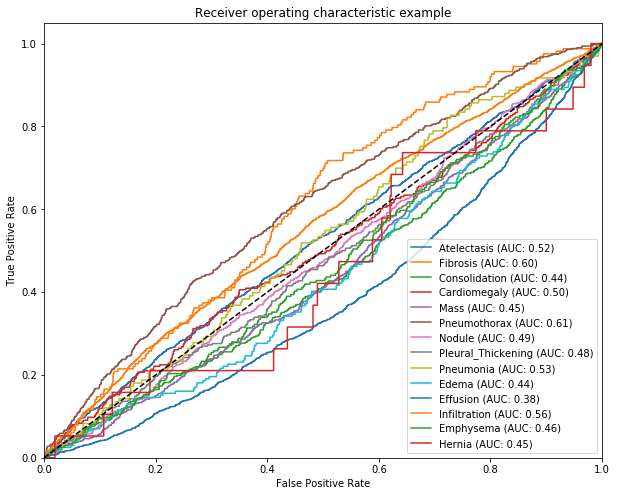

In [99]:
plot_auc_curves(model_eval)

In [215]:
obs_id = 7
p, a = model_eval.score_obs((img_data_train[obs_id][0].unsqueeze(0), img_data_train[obs_id][1].unsqueeze(0)))

In [ ]:
m = MultiClassAUCMeter(14)

In [216]:
m.add(p.data, a.data)

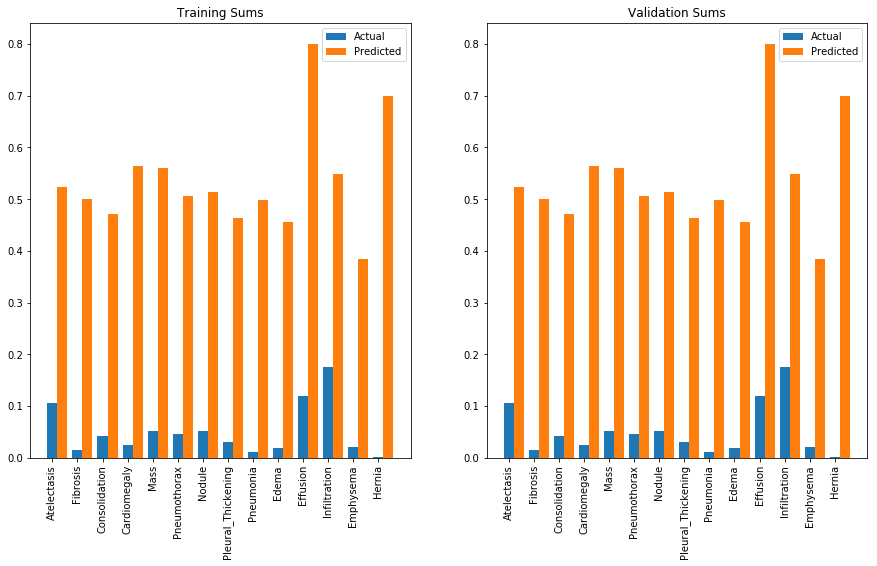

In [116]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title("Training Sums")
plot_compare_sums(eval_val)

plt.subplot(1,2,2)
plt.title("Validation Sums")
plot_compare_sums(eval_val)

In [54]:
out_model_30.train(mode=False)

obs_counter = 0
total_pred = Variable(torch.FloatTensor(torch.zeros(14)))
total_act = Variable(torch.FloatTensor(torch.zeros(14)))

conf_a = {}
conf_b = {}
conf_c = {}
conf_d = {}
for i in range(1,10):
    conf_a[i] = Variable(torch.FloatTensor(torch.zeros(14)))
    conf_b[i] = Variable(torch.FloatTensor(torch.zeros(14)))
    conf_c[i] = Variable(torch.FloatTensor(torch.zeros(14)))
    conf_d[i] = Variable(torch.FloatTensor(torch.zeros(14)))

for data in dataloaders['val']:
    print("STARTING ITERATION...")
    inputs, labels = data
    print("PROCESSING FIRST {} OBSERVATIONS".format(len(inputs)))

    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())

    outputs = out_model_30(inputs).sigmoid()
    
    total_act += labels.sum(0).cpu()
    total_pred += outputs.sum(0).cpu()

    # Store statistics (convert from autograd.Variable to float/int)
    for i in range(1,10):
        t = i/10
        conf_a[i] += ((outputs.sigmoid()>t) == (labels>0.5)).sum(0).cpu().float()
        conf_b[i] += ((outputs.sigmoid()<t) == (labels>0.5)).sum(0).cpu().float()
        conf_c[i] += ((outputs.sigmoid()>t) == (labels<0.5)).sum(0).cpu().float()
        conf_d[i] += ((outputs.sigmoid()<t) == (labels<0.5)).sum(0).cpu().float()

    obs_counter += len(inputs)

STARTING ITERATION...
PROCESSING FIRST 750 OBSERVATIONS
STARTING ITERATION...
PROCESSING FIRST 406 OBSERVATIONS


In [67]:
comparison = Variable(torch.FloatTensor(9, 14))
for i in range(9):
    comparison[0] = conf_a[1] / obs_counter
print(comparison.int())

Variable containing:

Columns 0 to 5 
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -2.1475e+09  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00 -2.1475e+09  0.0000e+00 -2.1475e+09  0.0000e+00
 6.2634e+06 -1.0000e+00 -2.1475e+09  0.0000e+00 -2.1475e+09  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00

Columns 6 to 11 
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00 -6.5460e+04  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
-2.1475e

In [101]:
'''
torch.save({
            'epoch': epoch+1,
            'state': model.state_dict(),
            'optimizer': optimizer,
            'scheduler': scheduler,
            'val_error': val_error
        }, model_out_path)
'''
test_load = torch.load('/user/xrayproj/output/20171120-01h41m56s_model_9.tar')

In [103]:
test_load.keys()

dict_keys(['epoch', 'state', 'optimizer', 'scheduler', 'val_error'])

In [106]:
load_opt = test_load['optimizer']
load_sched = test_load['scheduler']
load_state = test_load['state']

In [117]:
model2 = models.resnet18(pretrained=True)
for param in model2.parameters():
    param.requires_grad = False

# Replace FC layer
model2.fc = nn.Linear(model2.fc.in_features, len(img_data_train.labels))

model2_c = DataParallel(model2).cuda()

In [118]:
model2_c.load_state_dict(load_state)

In [123]:
model2_c.forward(Variable(img_data_train[0][0].unsqueeze(0).cuda())).sigmoid()

Variable containing:

Columns 0 to 9 
 0.7873  0.5093  0.2980  0.6386  0.4665  0.3371  0.1614  0.1846  0.1925  0.6630

Columns 10 to 13 
 0.0288  0.4468  0.3684  0.2549
[torch.cuda.FloatTensor of size 1x14 (GPU 0)]

In [ ]:
def single_model_run(model, dataset):
    dataset
    for data in self.dataset:
        inputs, actuals = data

        inputs = Variable(inputs.cuda(), volatile=True)
        actuals = Variable(actuals.cuda(), volatile=True)

        outputs = self.model(inputs)
        preds = outputs.sigmoid()

        self.m_total_sums.update(preds, actuals)
        self.m_auc.add(preds, actuals)